## Question 1 (10 points): 

How many houses are in this dataset?
* There are 19,451 houses

How many **features** are there for predicting house price? 
- There are 7 features for predicting house prices: sqft_living, sqft_loft, lat, long, bedrooms, bathrooms, and yr_built

Are there any null values in this dataset?
- No there are no null values in this dataset

Which three variables are best correlated with house price (include correlation coefficients)?
- The three best correlated variables are sqft_living(0.702296), bathrooms(0.524395), and bedrooms(0.315804)

Which three variables are least correlated with house price (include correlation coefficients)?
- The three least correated variables are sqft_loft (0.090125), yr_built (0.052453), and long (0.020092)


*******

## Question 2 (30 points):

* Produce a model to predict house prices. You are welcome to generate new features, scale the data, and split the data into training/testing (i.e. `train_test_split`) in any way you like. 


* Evaluate your model's accuracy by predicting a test dataset, for example:

`predictions = forest_reg.predict(X_test)
final_mse = mean_squared_error(y_test, predictions)
final_rmse = np.sqrt(final_mse)`


* Push your `lab5_submission.ipynb` to GitHub and submit a `.pdf` version to Canvas 



* On **Monday** the instructor and TA will provide an **unseen set of houses** which students will use to repeat their accuracy evaluation. The best models (i.e. lowest RMSE) will win prizes. 


* We will evaluate the models using a simple `mean-squared-error` as follows:

`mse = mean_squared_error(y_test , predictions)
rmse = np.sqrt(final_mse)`

------

### Import Libraries and Data

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [2]:
# Import data
df = pd.read_csv('C:\\Users\\littl\\Dropbox (University of Oregon)\\lab5 (1)\\seattle_house_prices.csv')

# Read dataset
coast = gpd.read_file('C:\\Users\\littl\\Dropbox (University of Oregon)\\lab5 (1)\\washington_coastline.shp')



## Part 1 - Questions

In [3]:
# Find the number of houses and the number of features
df.count()

price          19451
bedrooms       19451
bathrooms      19451
sqft_living    19451
sqft_lot       19451
yr_built       19451
lat            19451
long           19451
dtype: int64

In [4]:
# Check if there are any null values
df.isnull().sum(axis = 0)

price          0
bedrooms       0
bathrooms      0
sqft_living    0
sqft_lot       0
yr_built       0
lat            0
long           0
dtype: int64

In [5]:
# Convert DataFrame to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df['long'], df['lat']))
gdf = gdf.set_crs(4326, allow_override=True)

# Reproject everything to UTM 10N (EPSG:32610)
gdf_utm = gdf.to_crs('EPSG:32610')
coast_utm = coast.to_crs('EPSG:32610')

In [6]:
# Compute correlation matrix
corr_matrix = gdf_utm.corr()

# Display just house value correlations
corr_matrix["price"].sort_values(ascending= False)

price          1.000000
sqft_living    0.702296
bathrooms      0.524395
bedrooms       0.315804
lat            0.308082
sqft_lot       0.090125
yr_built       0.052453
long           0.020092
Name: price, dtype: float64

## Part 2 - Machine Learning

### Distance from Coast

In [7]:
# Compute distance to coast
distance_to_coast = []
for i in range(gdf_utm.shape[0]):
    distance_to_coast.append(coast_utm.distance(gdf_utm['geometry'].iloc[i]).min())
    
# Add to DataFrame
gdf_utm['distance_to_coast'] = distance_to_coast

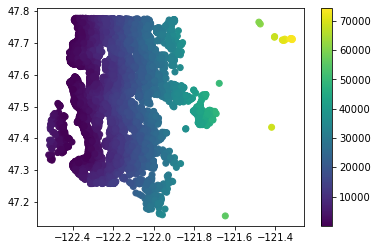

In [16]:
# Quickly check that it worked!
plt.scatter(gdf_utm['long'], gdf_utm['lat'], c=gdf_utm['distance_to_coast'])
plt.colorbar()

### Distance from Ballard

In [8]:
# 47.676922600299214, -122.38743820650602
from shapely.geometry import Point
geom = Point (-122.38743820650602, 47.676922600299214)
geom_gdf = gpd.GeoDataFrame(geometry = [geom], crs = 4326)
geom_gdf = geom_gdf.to_crs("EPSG:32610")

distance_to_Ballard =  []
for i in range (gdf_utm.shape[0]):
    distance_to_Ballard.append(geom_gdf.distance(gdf_utm['geometry'].iloc[i]).min())

                             #add to dataframe
                             
gdf_utm['distance_to_Ballard'] = distance_to_Ballard

### Distance from Denny-Blaine

In [9]:
# 47.62155854342593, -122.28571207751416
from shapely.geometry import Point
geom = Point (-122.28571207751416, 47.62155854342593)
geom_gdf = gpd.GeoDataFrame(geometry = [geom], crs = 4326)
geom_gdf = geom_gdf.to_crs("EPSG:32610")

distance_to_DennyBlaine =  []
for i in range (gdf_utm.shape[0]):
    distance_to_DennyBlaine.append(geom_gdf.distance(gdf_utm['geometry'].iloc[i]).min())

                             #add to dataframe
                             
gdf_utm['distance_to_DennyBlaine'] = distance_to_DennyBlaine

### Distance to Pike Place Market

In [10]:
# 47.60973438300838, -122.34226805937116

from shapely.geometry import Point
geom = Point (-122.34226805937116, 47.60973438300838)
geom_gdf = gpd.GeoDataFrame(geometry = [geom], crs = 4326)
geom_gdf = geom_gdf.to_crs("EPSG:32610")

distance_to_Pike =  []
for i in range (gdf_utm.shape[0]):
    distance_to_Pike.append(geom_gdf.distance(gdf_utm['geometry'].iloc[i]).min())

                             #add to dataframe
                             
gdf_utm['distance_to_Pike'] = distance_to_Pike

### Correlation matrix

In [11]:
# Define feature list
feature_list =  ['sqft_living', 'bathrooms', 
                 'bedrooms', 'lat', 'sqft_lot', 'yr_built', 'long', 'distance_to_coast', 'distance_to_Ballard', 'distance_to_Pike', 'distance_to_DennyBlaine']

# Define features and labels 
X = gdf_utm[feature_list]
y = gdf_utm['price']

# Standarize data
scaler = StandardScaler()  
X_scaled = scaler.fit_transform(X)

In [12]:
# Split data 
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [13]:
# Define model
forest_reg = RandomForestRegressor(n_estimators = 30)

# Fit model
forest_reg.fit(X_train, y_train)

RandomForestRegressor(n_estimators=30)

In [14]:
gdf_utm = gdf_utm.loc[:, gdf_utm.columns != "distance_to_schools"]


In [15]:
gdf_utm.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'yr_built',
       'lat', 'long', 'geometry', 'distance_to_coast', 'distance_to_Ballard',
       'distance_to_DennyBlaine', 'distance_to_Pike'],
      dtype='object')

In [17]:
len(gdf_utm.columns)

13

In [18]:
# Compute correlation matrix
corr_matrix = gdf_utm.corr()

# Display just house value correlations
corr_matrix["price"].sort_values(ascending= False)

price                      1.000000
sqft_living                0.702296
bathrooms                  0.524395
bedrooms                   0.315804
lat                        0.308082
sqft_lot                   0.090125
yr_built                   0.052453
distance_to_coast          0.027830
long                       0.020092
distance_to_Ballard       -0.280954
distance_to_Pike          -0.285356
distance_to_DennyBlaine   -0.352491
Name: price, dtype: float64

## Evaluate model

In [19]:
# Predict test labels predictions
predictions = forest_reg.predict(X_test)

# Compute mean-squared-error
final_mse = mean_squared_error(y_test , predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

# output number is the number of errors
# the lower the number the better the model

151018.210729662

## Plot

(0.0, 500000.0)

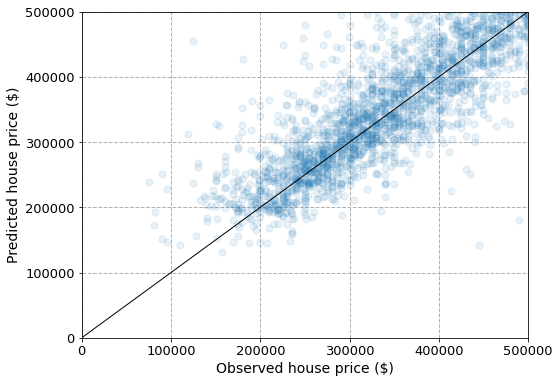

In [20]:
# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y_test, predictions, alpha=0.1, s=50, zorder=2)
ax.plot([0,500000], [0, 500000], color='k', lw=1, zorder=3)
ax.set_ylabel('Predicted house price ($)', fontsize=14)
ax.set_xlabel('Observed house price ($)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=13)
ax.grid(ls='dashed', lw=1, zorder=1)
ax.set_ylim(0,500000)
ax.set_xlim(0,500000)